# Assignment 3 - Stochastic Processes

    Name: Clara Periago
    Student #: s1067476

In [537]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.experimental import io_callback
from pathlib import Path
import opensimplex as opsx
import fastplotlib as fpl
import numpy as np
from pathlib import Path

In [538]:
# these are copy pasted from the last exercise
def rk4(f, dt):
    @jax.jit
    def step(x, t):
        k1 = f(t, x)
        k2 = f(t + .5 * dt, x + .5 * dt * k1)
        k3 = f(t + .5 * dt, x + .5 * dt * k2)
        k4 = f(t + dt, x + dt * k3)

        xn1 = x + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
        return xn1

    return step

In [559]:
lapl = jnp.array(
    [[0.05, 0.2, 0.05],
     [0.2, -1.0, 0.2],
     [0.05, 0.2, 0.05]]
)
dx = 2.
lapl = lapl / (dx * dx)


def save_figure(fig, filename: str | Path):
    figure_dir = Path("../project-report/img").resolve()
    f = figure_dir / filename
    print(f"Saving figure output to {f}")
    fig.savefig(f, dpi=300, bbox_inches="tight")

def diffuse(k_i, dk):
    return dk * jax.scipy.signal.convolve2d(k_i, lapl, mode="same", boundary="fill", fillvalue=0)

def step_n(solver, n):
    def _step(x, _=None):
        def body(x, _):
            return solver(x, 0.0), None
        x, _ = jax.lax.scan(body, x, None, length=n)
        return x, x
    return _step

def capacity_from_height(H, strength=0.3, gamma=2.0):
    return 1.0 - strength * jnp.abs(H) ** gamma

def bunny_dynamics(dK, dt, feed, kill, reproduction, grass_consumption, terrain):
    H = terrain # (w, h)
    # max carrying capacity of grass at (x, y), given heightmap
    K_G = capacity_from_height(H)

    def f(t, c):
        K = c  # (S+1, w, h)
        G = K[0]          # grass
        B = K[1:]         # bunnies

        # reproduction
        r  = reproduction[:, None, None]      # (S, 1, 1)
        R = r * G * B**2 + 0.01 * r * G * B

        # grass consumption
        # grass is determined by a max of K_G
        # and it is reduced by the grass consumption of each bunny species
        # times the amount of new bunnies R
        dG = feed * (K_G - G) - jnp.sum(grass_consumption[:, None, None] * R, axis=0)
    
        # bunnie increase follows normal reaction diffusion
        dB = R - (kill + feed)[:, None, None] * B

        # we mix a percentage of species to avoid harsh borders
        mix_eps = 0.05
        total_B = jnp.sum(B, axis=0, keepdims=True)
        dB += mix_eps * (total_B - B) * (G > 0.8)

        # diffusion
        k_diffused = jax.vmap(diffuse, in_axes=(0, 0))(K, dK)

        # next_K = k_diffused + jnp.array([dG, dB1, dB2])
        next_K = k_diffused + jnp.concatenate(
            [jnp.array([dG]), dB]
        )
        
        return next_K

    solver = jax.jit(rk4(f, dt))
    return solver

def draw_circle(grid, cx, cy, radius, strength, channel=1):
    """
    grid: (C, W, H)
    cx, cy: center coordinates
    radius: circle radius
    value: value to write inside the circle
    channel: which channel to write to
    """
    _, w, h = grid.shape

    xs = jnp.arange(w)[:, None]
    ys = jnp.arange(h)[None, :]

    # mask = (xs - cx)**2 + (ys - cy)**2 <= radius**2
    dist2 = (xs - cx)**2 + (ys - cy)**2
    brush = jnp.exp(-dist2 / (2 * radius**2))

    return grid.at[channel].add(strength * brush)


    # return grid.at[channel].set(
    #     jnp.where(mask, value, grid[channel])
    # )

def get_heightmap(w, h, seed, scale=24., regenerate=False):
    fname = f"heightmap_w{w}_h{h}_seed{seed}_scale{scale}.npy"
    out_dir = Path('./out')
    out_dir.mkdir(exist_ok=True)

    file = out_dir / fname
    if file.exists() and not regenerate:
        return jnp.asarray(np.load(file))
    
    opsx.seed(seed)
    heightmap = opsx.noise2array(
        jnp.arange(w) / scale,
        jnp.arange(h) / scale
    )
    np.save(file, np.asarray(.5 * (1. + heightmap)))
    return heightmap

def reset_grid(w, h, nK, key_n=42, seed_size=110):
    key = jr.key(key_n)
    
    grid = jnp.zeros((nK, w, h)).at[0].set(1.)

    # (S, n_locations, 2), last dimension corresponds to x,y
    seed_locations = jr.uniform(key, shape=(nK - 1, seed_size, 2), minval=0., maxval=jnp.array([w, h]))
    for i, channel in enumerate(seed_locations):
        for x, y in channel:
            grid = draw_circle(grid, x, y, 2, .6, channel=i+1)
    # grid = draw_circle(grid, w//2-5, h//2-5, 5, .4, channel=1)
    heightmap = get_heightmap(w, h, seed=key_n)

    return grid, heightmap

In [540]:
dt = 1.
t = jnp.arange(0, 1000, dt)
dK = jnp.array([1.0, 0.5, 0.5])
w, h = 320, 320

nK = len(dK) # number of total species
nS = nK - 1 # number of bunny species
# nS = 1

grid, heightmap = reset_grid(w, h, nS + 1)
# heightmap = jnp.zeros((w, h)) # for disabling the terrain
# gc = jnp.array([.95, .95]) # 2 bunnies
gc = jnp.array([1.]) # 1 bunnie

solver = bunny_dynamics(
    dK[:nS+1], dt,
    feed=.0367,
    kill=jnp.array([.0649, .05])[:nS],
    reproduction=jnp.array([1., .75])[:nS],
    grass_consumption=gc,
    terrain=heightmap
)
s0 = grid  # initial state

Saving figure output to /Users/clara/uni/master/complex-adaptive-systems/project-report/img/s0.png


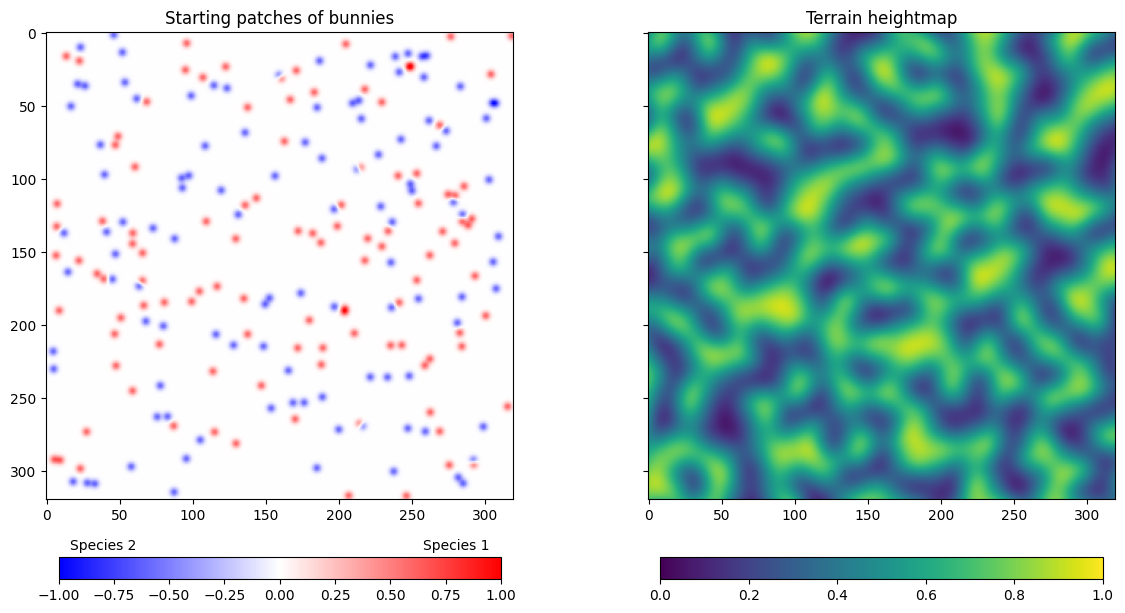

In [541]:
fig, (ax1, ax2) = plt.subplots(
    figsize=(12, 6), ncols=2,
    sharey=True,
    layout='constrained'
)

ima = ax1.imshow(s0[1]-s0[2], cmap='bwr', vmin=-1., vmax=1.)
cba = plt.colorbar(ima, shrink=.75, orientation="horizontal", pad=0.03)
cba.ax.text(.8, 1.5, 'Species 1', ha='center', va='center')
cba.ax.text(-.8, 1.5, 'Species 2', ha='center', va='center')
ax1.set_title('Starting patches of bunnies')
# ax1.imshow(s0[2])
imb = ax2.imshow(heightmap, vmin=0., vmax=1.)
cbb = plt.colorbar(imb, shrink=.75, orientation="horizontal", pad=0.03)
cbb.ax.text(0., 1.5, ' ', ha='center', va='center') # otherwise the colorbars are not aligned
ax2.set_title('Terrain heightmap')
save_figure(fig, 's0.png')

In [542]:
import skimage.measure as measure

levels = jnp.linspace(heightmap.min(), heightmap.max(), 8)
contours = []
for level in levels:
    cc = measure.find_contours(np.asarray(heightmap), level)
    for c in cc:
        if c.shape[0] >= 2:   # must have at least 2 points
            contours.append(c[:, ::-1])

In [532]:
len(contours[1])
fig = fpl.Figure(size=(700, 560))
fig[0, 0].add_image(heightmap)
fig[0, 0].add_line_collection(
    data=contours,
    colors=(0, 0, 0, 0.25),  # translucent black
    cmap="hot",
    thickness=1.4,
)
fig.show()

IndexError: list index out of range

RFBOutputContext()

JupyterRenderCanvas(css_height='1080.0px', css_width='1920.0px')
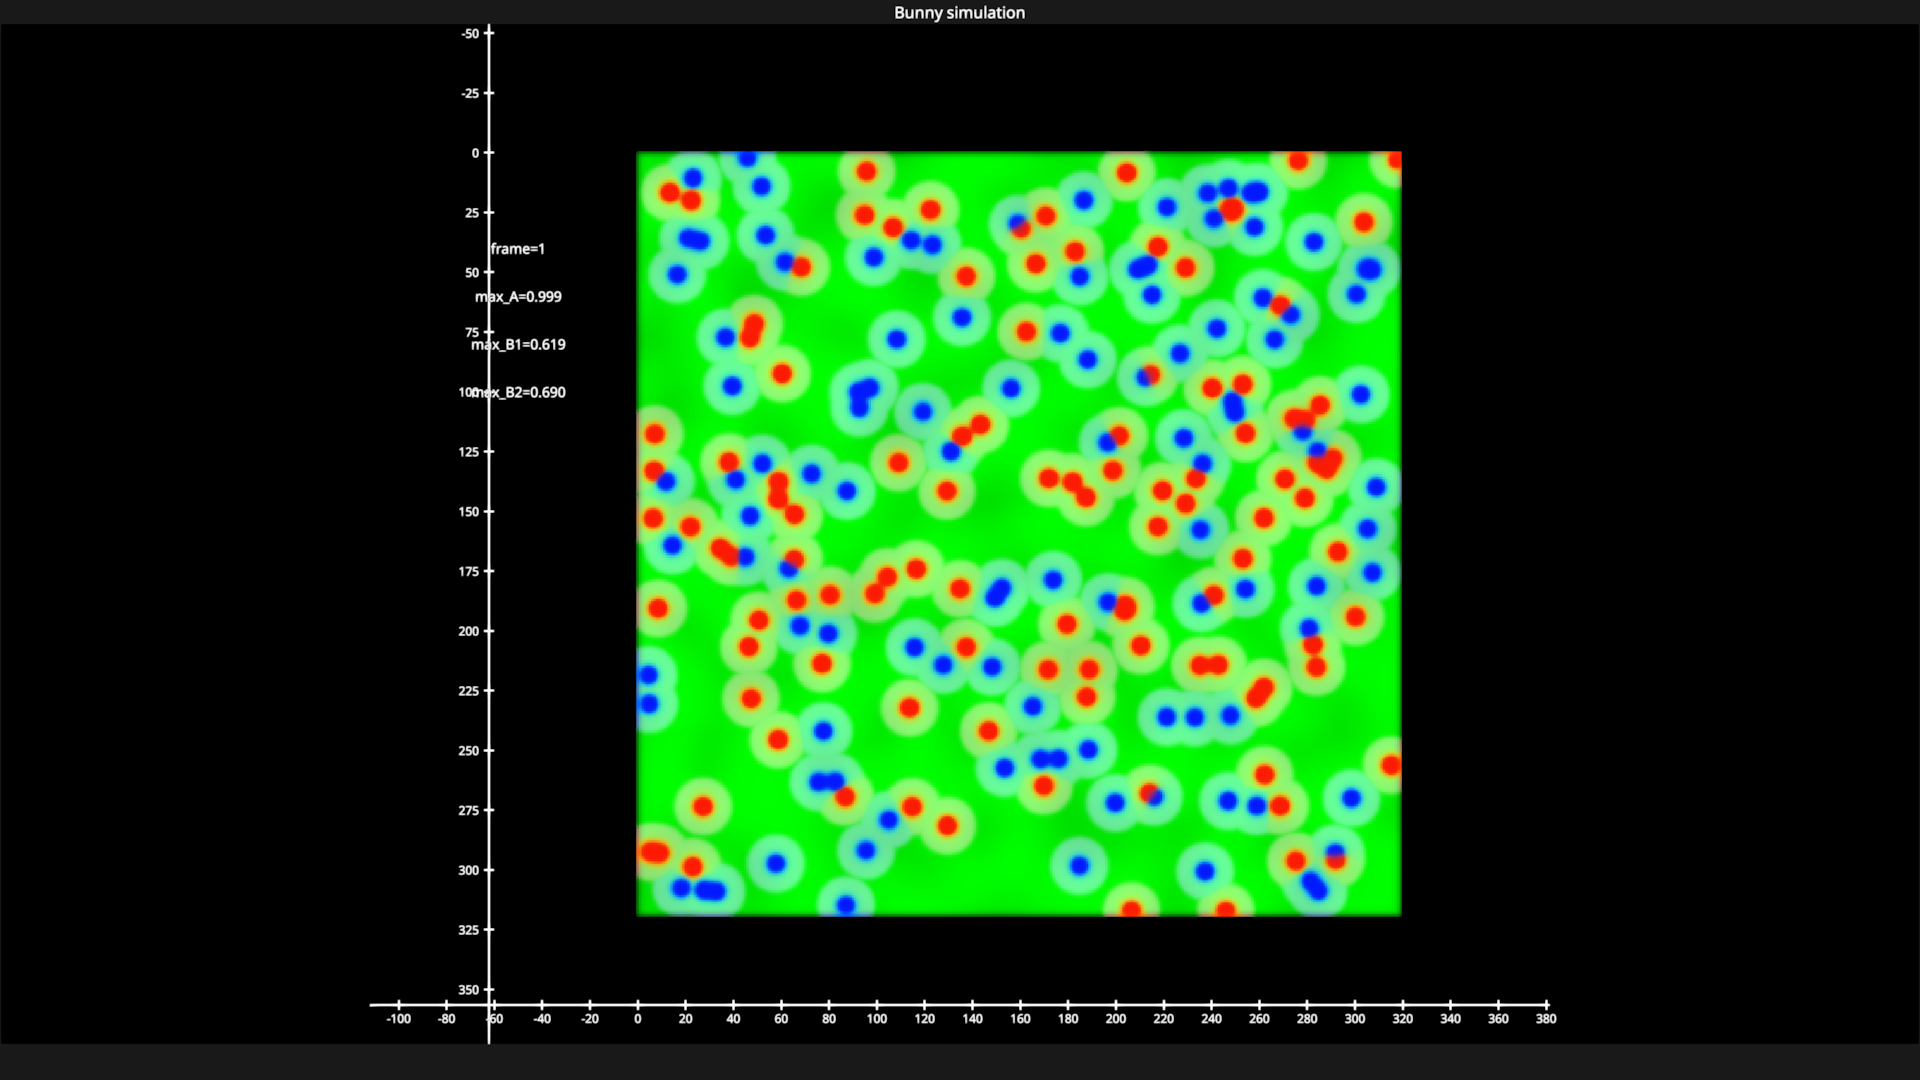

Draw error: 'Figure' object is not subscriptable (3)
Draw error: 'Figure' object is not subscriptable (17)
Draw error: 'Figure' object is not subscriptable (21)


In [536]:
fig = fpl.Figure(size=(1920, 1080))
fig.canvas.max_buffered_frames = 1

fig[0, 0].title = "Bunny simulation"
lc = fig[0, 0].add_line_collection(
    data=contours,
    colors=(0, 0, 0, 0.25),  # translucent black
    cmap="plasma",
    thickness=1.4,
)
lc.visible = False

data = jnp.zeros((320, 320, 3))
image = fig[0, 0].add_image(
    data=data,
    name="random-image",
    # cmap="Spectral",
    vmin=0.,
    vmax=1.,
    # offset=(0., 0., 2.),
)
cmap = plt.colormaps.get_cmap("Spectral")

fig[0, 0].add_text(text="0", name="frame", offset=(-50, 40, 0))
fig[0, 0].add_text(text="0", name="max_G", offset=(-50, 60, 0))
for i in range(nS):
    fig[0, 0].add_text(text="0", name=f"max_B{i+1}", offset=(-50, 80+i*20, 0))

marker_index = 0
current_x = s0
STEPS_PER_FRAME = 20
stepper = jax.jit(step_n(solver, STEPS_PER_FRAME))

idx_save = [50, 100, 250, 500]

# for level_contours in contours:
#     for c in level_contours:
#         fig[0, 0].add_line(
#             data=c,
#             colors=(0, 0, 0, 0.25),  # translucent black
#             thickness=2,
#             uniform_color=True,
#             offset=(0,0,0),
#             #name="terrain-contour"
#         )

# a function to update the image
# a figure-level animation function will optionally take the figure as an argument
import imageio.v3 as iio
def save_fig_fpl(fig, path):
    # fig.export(path)
    # frame = figure.export_numpy(rgb=True)
    iio.imwrite(path, frame)

def update_data():
    global marker_index, current_x
    marker_index += 1

    if marker_index == t.shape[0]:
        marker_index = 0

    current_x = stepper(current_x)

    x = jnp.clip(current_x, 0, 1)
    grass = x[0]
    bunnies = x[1:]
    total = bunnies.sum(axis=0) + 1e-6
    # frame = B1
    density = jnp.tanh(4.0 * total)

    B1 = bunnies[0]
    B2 = bunnies[1] if nS > 1 else jnp.zeros_like(B1)

    if bunnies.shape[0] > 1 or True:
        R = B1 / total
        G = grass
        B = B2 / total
        rgb = jnp.stack([R, G, B], axis=-1)
    else:
        rgb = cmap(B1)[..., :3]
    # rgb = rgb * density[..., None]
    
    # Hn = (heightmap - heightmap.min()) / (heightmap.max() - heightmap.min())
    # shade = .7 + .4 * Hn
    # rgb = rgb * shade[..., None]
    
    fig[0, 0]["random-image"].data = rgb
    fig[0, 0]["frame"].text = f"frame={marker_index}"
    fig[0, 0]["max_G"].text = f"max_A={jnp.max(grass):.3f}"
    for i in range(nS):
        fig[0, 0][f"max_B{i+1}"].text = f"max_B{i+1}={jnp.max(bunnies[i]):.3f}"

    # if marker_index in idx_save:
    #     save_fig_fpl(rgb, f'./out/pics/{marker_index}.png')

# def update_data_post():
#     if marker_index in idx_save:
#         # save_fig_fpl(fig, f'./out/pics/{marker_index}.png')
#         fig.export(f'./out/pics/{marker_index}.png')


@fig.renderer.add_event_handler("key_down")
def toggle(ev):
    if ev.key == "t":
        for g in fig[0, 0].graphics:
            if isinstance(g, fpl.LineGraphic) or isinstance(g, fpl.LineCollection):
                g.visible = not g.visible
    if ev.key == "s":
        tt = ['max_G', 'max_B1', 'max_B2', 'frame']
        def toggle(v):
            for g in fig[0, 0].graphics:
                print(g.name)
                if g.name in tt:
                    g.visible = v
        toggle(False)
        fig.export(f'./out/pics/{marker_index}.png')
        toggle(True)

@image.add_event_handler("pointer_down")
def click_event(ev):
    global current_x
    # get the click location in screen coordinates
    xy = (ev.x, ev.y)
    ev.stop_propagation()

    # map the screen coordinates to world coordinates
    xy = fig[0, 0].map_screen_to_world(xy)[:-1]
    y, x = jnp.array(xy, dtype=int)

    # print the click location
    ch = ev.button
    current_x = draw_circle(current_x, x, y, 2, .3, channel=ch)
    print(x, y)

# you can also add animation functions to individual subplots
def update_data_subplot(subplot_instance):
    pass

# add this as an animation function
fig.add_animations(update_data)
# fig.add_animations(update_data_post, pre_render=False, post_render=True)

# similarly you can add animation function to a subplot
# fig[0, 0].add_animations(update_data_subplot)

# show the plot
fig.show()

In [616]:
from dataclasses import dataclass


@dataclass
class Result:
    def __init__(
        self,
        max_ns: int | None = None,
        flat_terrain=False,
        grass_consumption: float | None = None,
        w=320,
        h=320,
        key_n=42
    ):
        """
        nS: number of bunny species
        """
        self.w = w
        self.h = h
        self.key_n = key_n

        self.nS = max_ns or nK - 1
        self.actual_nK = self.nS + 1

        self.s0, self.heightmap = reset_grid(self.w, self.h, self.actual_nK, key_n=key_n)
        self.gc = grass_consumption

        self.flat_terrain = flat_terrain  # for disabling the terrain
        if self.flat_terrain:
            self.heightmap = jnp.zeros((w, h))

        self.gc = jnp.full(
            (self.nS,), 0.95 if grass_consumption is None else grass_consumption
        )

        self.solver = bunny_dynamics(
            dK[: self.actual_nK],
            dt,
            feed=0.0367,
            kill=jnp.array([0.0649, 0.05])[: self.nS],
            reproduction=jnp.array([1.0, 0.75])[: self.nS],
            grass_consumption=self.gc,
            terrain=self.heightmap,
        )

        self.xs = self.xs_history = None

    def _fmt_(self):
        a = f"{self.w}x{self.h}_ns={self.nS}"
        if self.flat_terrain:
            a += "_flat"
        return a

    def __str__(self):
        return f"Result(n_bunnies={self.nS}, flat={self.flat_terrain})"

    def simulate(self, max_steps=750, steps_per_frame=20):
        # step over the solver but not every single frame
        stepper = jax.jit(step_n(self.solver, steps_per_frame))
        self.xs, self.xs_history = jax.lax.scan(stepper, s0, length=max_steps)

        # return self.xs, self.xs_history

    def render(self, idx=-1, cmap=None):
        if self.xs is None or self.xs_history is None:
            raise ValueError("call simulate first")

        return render_frame(self.xs_history[idx], self.heightmap, cmap)

    def print_at(self, save_at: set = {50, 100, 250, 500}, cmap=None, save_dir: Path | None=None):
        if self.xs is None or self.xs_history is None:
            raise ValueError("call simulate first")
        save_at = jnp.array(list(
            save_at.union({0, len(self.xs_history)})
        ), dtype=jnp.int16)

        rgbs = jax.vmap(self.render, (0, None))(save_at, cmap)

        if save_dir is not None:
            for r, i in zip(rgbs, save_at):
                fname = save_dir / f"{self._fmt_()}_i{i}.png"
                iio.imwrite(fname, r)
                print("Saved to", fname)

        return rgbs

def render_frame(frame, heightmap, cmap=None):
    x = jnp.clip(frame, 0, 1)
    grass = x[0]
    bunnies = x[1:]
    total = bunnies.sum(axis=0) + 1e-6
    # frame = B1
    density = jnp.tanh(4.0 * total)

    B1 = bunnies[0]
    nS = len(bunnies)
    B2 = bunnies[1] if nS > 1 else jnp.zeros_like(B1)

    if bunnies.shape[0] > 1 or cmap is None:
        R = B1 / total
        G = grass
        B = B2 / total
        rgb = jnp.stack([R, G, B], axis=-1)
    else:
        rgb = cmap(B1)[..., :3]
    rgb = rgb * density[..., None]

    if heightmap is not None:
        # shade the terrain a bit
        Hn = (heightmap - heightmap.min()) / (heightmap.max() - heightmap.min())
        shade = 0.7 + 0.4 * Hn
        rgb = rgb * shade[..., None]

    return (jnp.clip(rgb, 0, 1) * 255).astype(jnp.uint8)

In [617]:
r1 = Result()

In [618]:
r1.simulate()

Saved to out/pics/320x320_ns=2_i0.png
Saved to out/pics/320x320_ns=2_i50.png
Saved to out/pics/320x320_ns=2_i100.png
Saved to out/pics/320x320_ns=2_i500.png
Saved to out/pics/320x320_ns=2_i250.png
Saved to out/pics/320x320_ns=2_i750.png


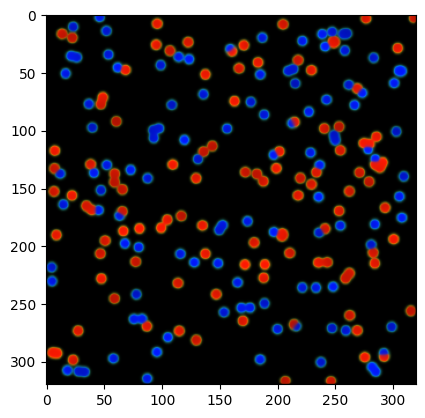

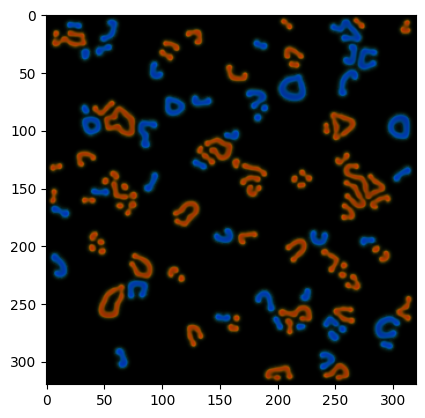

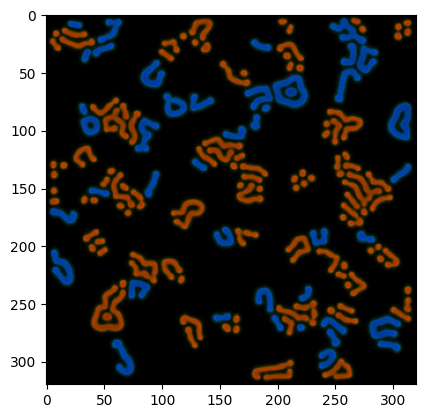

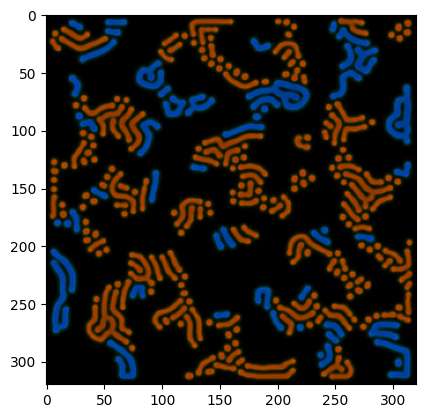

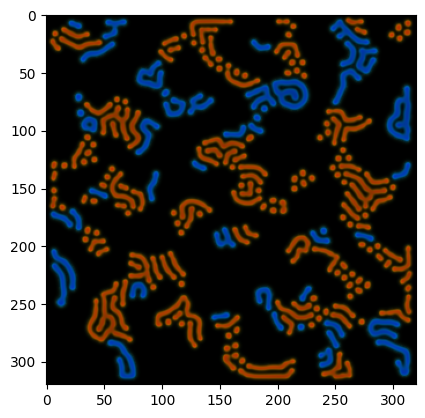

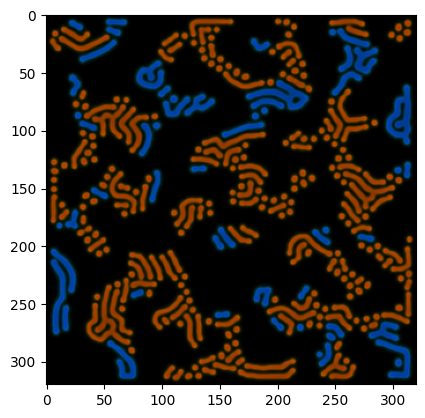

In [619]:
rgbs = r1.print_at(save_dir=Path('./out/pics'))

for r in rgbs:
    plt.imshow(r)
    plt.show()